# Couple candlestick - Analytics

### Import Library

In [71]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [72]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [73]:
data = dataset.copy()

In [74]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [75]:
def set_condition_1(r):
    cond = ''
    if r['Open'] > r['Close'] >= r['Low'] + 0.1:
        # Do va co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] <= r['High'] - 0.1:
        # Xanh va co bong nen tren
        cond = 'long'
    return cond


def set_condition_2(r):
    cond = ''
    if r['Open'] > r['Close'] == r['Low'] and r['Low'] < r['low_s1']:
        # Do va khong co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] == r['High'] and r['High'] > r['high_s1']:
        # Xanh va khong co bong nen tren
        cond = 'long'
    return cond
    

def get_couple_candleticks_signal(r):
    signal = ''
    if r['condition_1'] == 'short' and r['condition_2'] == 'short':
        signal = 'short'
    elif r['condition_1'] == 'long' and r['condition_2'] == 'long':
        signal = 'long'
    return signal

In [76]:
# Couple candlesticks signal
data['low_s1'] = data['Low'].shift(1)
data['high_s1'] = data['High'].shift(1)
data['max_5'] = data['High'].rolling(5).max()
data['min_5'] = data['Low'].rolling(5).min()
data['condition_1'] = data.apply(lambda r: set_condition_1(r), axis=1)
data['condition_1'] = data['condition_1'].shift(1)
data['condition_2'] = data.apply(lambda r: set_condition_2(r), axis=1)
data['couple_cs_signal'] = data.apply(lambda r: get_couple_candleticks_signal(r), axis=1)

In [77]:
data[data['couple_cs_signal'] != '']

,Open,High,Low,Close,Volume,low_s1,high_s1,max_5,min_5,condition_1,condition_2,couple_cs_signal
Date,,,,,,,,,,,,
2020-11-02 10:05:00,900.0,900.4,899.5,899.5,1044,900.0,901.3,901.4,897.7,short,short,short
2020-11-02 14:25:00,904.9,907.0,904.5,907.0,5873,899.0,905.5,907.0,896.6,long,long,long
2020-11-03 09:20:00,908.5,908.8,908.1,908.1,847,908.3,908.9,909.4,908.1,short,short,short
2020-11-04 09:35:00,907.8,908.0,907.3,907.3,1361,907.5,908.4,908.8,907.3,short,short,short
2020-11-04 10:05:00,908.2,909.0,908.1,909.0,1800,907.9,908.6,909.0,906.8,long,long,long
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-12 09:20:00,1340.4,1340.5,1339.3,1339.3,2902,1339.9,1341.4,1341.4,1337.4,short,short,short
2025-02-12 14:25:00,1335.7,1335.8,1332.8,1332.8,10417,1335.2,1337.1,1338.0,1332.8,short,short,short
2025-02-13 10:40:00,1328.7,1329.8,1328.6,1329.8,4716,1327.4,1328.8,1329.8,1326.2,long,long,long


In [78]:
data['max_high_25bars_later'] = data['High'].shift(-25).rolling(25).max()
data['min_low_25bars_later'] = data['Low'].shift(-25).rolling(25).min()

In [79]:
data['RSI'] = ta.rsi(data["Close"], length=14)
data['RSI'] = round(data['RSI'])

In [80]:
# Identify Lower Low (LL) and Higher RSI
data['LL'] = data['Low'] < data['Low'].shift(1).rolling(20).min() - 0.1
data['Higher_RSI'] = data['RSI'] > data['RSI'].shift(1).rolling(20).min()
# Find divergence signals
data['bullish_signal'] = data.apply(lambda r: 1 if r['LL'] & r['Higher_RSI'] else 0, axis=1)

In [81]:
# Identify Higher High (HH) and Lower RSI
data['HH'] = data['High'] > data['High'].shift(1).rolling(20).max() + 0.1
data['Lower_RSI'] = data['RSI'] < data['RSI'].shift(1).rolling(20).max()
# Find divergence signals
data['bearish_signal'] = data.apply(lambda r: 1 if r['HH'] & r['Lower_RSI'] else 0, axis=1)

In [82]:
# Bullish Fair Value Gap: Previous High < Next Low (Upward imbalance)
data["Bullish_FVG"] = data["High"].shift(2) < data["Low"]
data['Bullish_FVG'] = data.apply(lambda r: 1 if r['Bullish_FVG'] else 0, axis=1)
# Bearish Fair Value Gap: Previous Low > Next High (Downward imbalance)
data["Bearish_FVG"] = data["Low"].shift(2) > data["High"]
data['Bullish_FVG'] = data.apply(lambda r: 1 if r['Bearish_FVG'] else 0, axis=1)

In [83]:
data.dropna(inplace=True)

In [84]:
data['pass_bearish_signal'] = data['bearish_signal'].rolling(10).sum()
data['pass_bullish_signal'] = data['bullish_signal'].rolling(10).sum()
data['pass_bearish_fvg'] = data['Bearish_FVG'].rolling(10).sum()
data['pass_bullish_fvg'] = data['Bullish_FVG'].rolling(10).sum()

In [85]:
def is_trap(r):
    trap = ''
    if r['couple_cs_signal'] == 'long':
        if r['min_low_25bars_later'] < r['Close'] - 3.5:
            trap = 'yes'
        else:
            trap = 'no'
    elif r['couple_cs_signal'] == 'short':
        if r['max_high_25bars_later'] > r['Close'] + 3.5:
            trap = 'yes'
        else:
            trap = 'no'
    return trap

In [86]:
data['trap'] = data.apply(lambda r: is_trap(r), axis=1)

In [87]:
data[data.trap != ''].tail(15)

,Open,High,Low,Close,Volume,low_s1,high_s1,max_5,min_5,condition_1,...,HH,Lower_RSI,bearish_signal,Bullish_FVG,Bearish_FVG,pass_bearish_signal,pass_bullish_signal,pass_bearish_fvg,pass_bullish_fvg,trap
Date,,,,,,,,,,,,,,,,,,,,,
2025-02-04 09:35:00,1322.6,1322.7,1321.8,1321.8,2083,1322.1,1323.3,1325.3,1321.8,short,...,False,True,0,1,True,0.0,0.0,2.0,2.0,yes
2025-02-04 10:40:00,1323.1,1323.2,1322.3,1322.3,2014,1322.8,1323.4,1324.6,1322.3,short,...,False,True,0,0,False,0.0,0.0,1.0,1.0,yes
2025-02-04 14:15:00,1328.4,1330.0,1328.4,1330.0,3796,1327.4,1329.1,1330.0,1327.3,long,...,True,True,1,0,False,2.0,0.0,0.0,0.0,no
2025-02-05 10:00:00,1334.2,1335.0,1334.2,1335.0,1500,1333.4,1334.5,1335.2,1333.4,long,...,False,True,0,0,False,1.0,0.0,0.0,0.0,yes
2025-02-05 13:15:00,1332.2,1332.5,1331.6,1331.6,1299,1332.0,1332.6,1332.6,1331.5,short,...,False,True,0,0,False,0.0,0.0,2.0,2.0,yes
2025-02-05 13:25:00,1331.7,1332.1,1330.9,1330.9,1833,1331.3,1332.2,1332.6,1330.9,short,...,False,True,0,0,False,0.0,0.0,1.0,1.0,yes
2025-02-05 13:50:00,1331.9,1333.4,1331.5,1333.4,5276,1330.6,1331.8,1333.4,1329.6,long,...,False,True,0,0,False,0.0,0.0,1.0,1.0,no
2025-02-06 09:55:00,1342.5,1344.3,1342.3,1344.3,4723,1341.5,1342.7,1344.3,1341.2,long,...,True,False,0,0,False,0.0,0.0,0.0,0.0,yes
2025-02-10 14:20:00,1333.5,1334.3,1332.2,1332.2,4219,1333.0,1334.7,1336.2,1332.2,short,...,False,True,0,0,False,0.0,0.0,1.0,1.0,no


In [88]:
len(data[data.trap == 'no'])

1021

In [89]:
len(data[(data.trap == 'no') & ((data.pass_bearish_signal > 0) | (data.pass_bullish_signal > 0))])

473

In [90]:
len(data[data.trap == 'yes'])

1318

In [91]:
len(data[(data.trap == 'yes') & ((data.pass_bearish_signal > 0) | (data.pass_bullish_signal > 0))])

638

## Long signals

In [99]:
long_signals = data[(data.trap != '') & (data.Close > data.Open)]

In [94]:
# Long Trap
data[(data.trap == 'yes') & (data.Close > data.Open) & (data.pass_bullish_signal > 0) & (data.pass_bullish_fvg > 0)]

,Open,High,Low,Close,Volume,low_s1,high_s1,max_5,min_5,condition_1,...,HH,Lower_RSI,bearish_signal,Bullish_FVG,Bearish_FVG,pass_bearish_signal,pass_bullish_signal,pass_bearish_fvg,pass_bullish_fvg,trap
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-20 10:20:00,1090.4,1100.0,1089.0,1100.0,4764,1085.2,1093.0,1107.0,1070.0,long,...,False,True,0,0,False,0.0,1.0,5.0,5.0,yes
2021-01-22 13:15:00,1174.0,1180.1,1174.0,1180.1,5483,1171.2,1175.0,1181.3,1171.2,long,...,False,True,0,0,False,0.0,1.0,3.0,3.0,yes
2021-01-26 11:25:00,1123.5,1135.4,1122.0,1135.4,7184,1117.0,1126.8,1148.7,1115.0,long,...,False,True,0,0,False,0.0,2.0,5.0,5.0,yes
2021-03-08 14:00:00,1165.9,1168.6,1165.6,1168.6,2734,1164.9,1167.6,1168.6,1162.2,long,...,False,True,0,0,False,0.0,2.0,2.0,2.0,yes
2021-03-09 09:25:00,1154.1,1156.8,1153.2,1156.8,4246,1151.9,1156.6,1163.0,1151.9,long,...,False,True,0,0,False,0.0,3.0,2.0,2.0,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-04 09:45:00,1306.7,1308.5,1306.5,1308.5,4385,1306.0,1307.0,1308.5,1306.0,long,...,False,True,0,0,False,0.0,2.0,3.0,3.0,yes
2025-01-07 14:25:00,1319.0,1319.8,1318.5,1319.8,5145,1315.7,1319.6,1322.1,1315.7,long,...,False,True,0,0,False,0.0,2.0,4.0,4.0,yes
2025-01-08 09:20:00,1316.4,1317.7,1315.8,1317.7,2556,1314.7,1316.6,1318.7,1314.7,long,...,False,True,0,0,False,0.0,3.0,4.0,4.0,yes


In [103]:
# Real Long Signal
long_signals[(long_signals.trap == 'no') & (long_signals.pass_bullish_signal > 0) & (long_signals.pass_bullish_fvg == 0)]

,Open,High,Low,Close,Volume,low_s1,high_s1,max_5,min_5,condition_1,...,HH,Lower_RSI,bearish_signal,Bullish_FVG,Bearish_FVG,pass_bearish_signal,pass_bullish_signal,pass_bearish_fvg,pass_bullish_fvg,trap
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-11 10:50:00,921.4,921.9,920.9,921.9,1331,920.8,921.6,921.9,919.4,long,...,False,False,0,0,False,0.0,1.0,0.0,0.0,yes
2021-09-07 13:25:00,1446.9,1448.0,1446.6,1448.0,3735,1446.2,1447.9,1448.0,1442.5,long,...,False,False,0,0,False,0.0,1.0,0.0,0.0,yes
2022-03-04 13:05:00,1514.1,1515.2,1514.1,1515.2,2521,1513.7,1514.7,1515.2,1513.0,long,...,False,True,0,0,False,0.0,1.0,0.0,0.0,yes
2022-04-08 09:40:00,1533.4,1534.5,1533.3,1534.5,2784,1531.7,1533.5,1534.5,1531.4,long,...,False,True,0,0,False,0.0,1.0,0.0,0.0,yes
2022-04-20 11:00:00,1453.5,1455.4,1453.5,1455.4,5243,1452.5,1454.3,1455.4,1447.2,long,...,False,False,0,0,False,0.0,2.0,0.0,0.0,yes
2022-07-11 11:10:00,1215.5,1216.8,1215.4,1216.8,2596,1214.6,1216.4,1216.8,1214.3,long,...,False,False,0,0,False,0.0,2.0,0.0,0.0,yes
2022-09-28 10:40:00,1168.5,1172.0,1167.6,1172.0,7844,1167.5,1168.8,1172.0,1167.5,long,...,False,False,0,0,False,0.0,1.0,0.0,0.0,yes
2022-12-20 14:15:00,1023.2,1031.4,1021.9,1031.4,16475,1017.8,1023.9,1031.4,1012.0,long,...,True,False,0,0,False,0.0,2.0,0.0,0.0,yes
2022-12-29 13:25:00,1005.0,1006.9,1004.5,1006.9,6648,1003.4,1005.1,1006.9,1002.5,long,...,False,True,0,0,False,0.0,1.0,0.0,0.0,yes


<Axes: xlabel='RSI'>

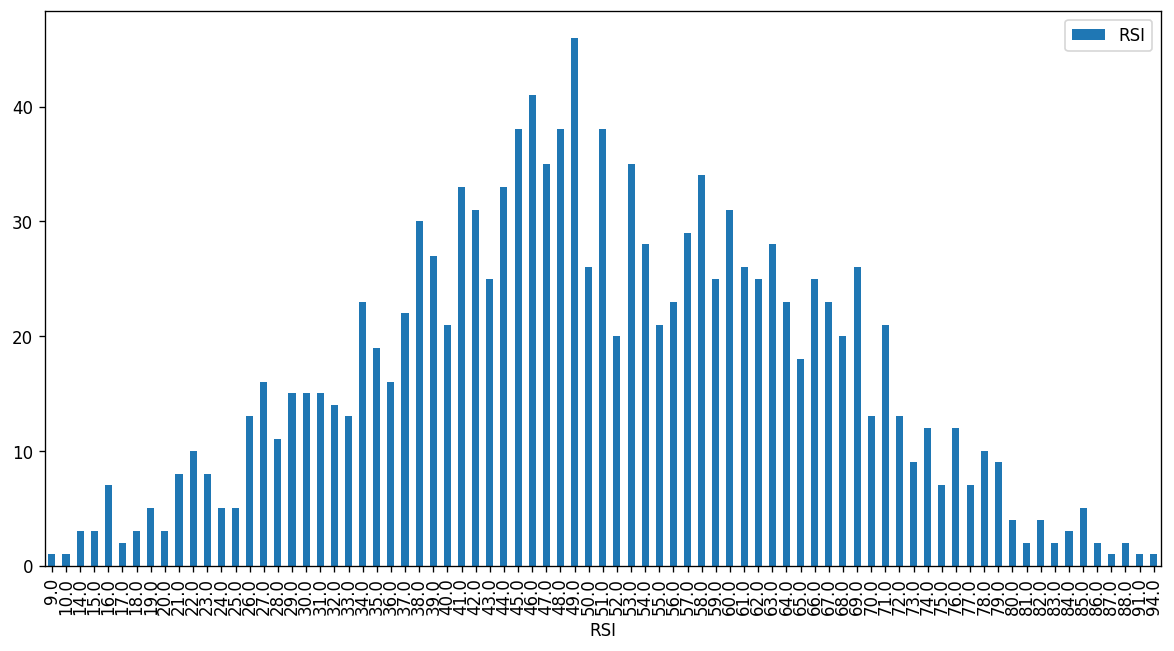

In [66]:
trap_data_grouped_by_rsi = data[data.trap == 'yes'].groupby(['RSI'])[['RSI']].count()
trap_data_grouped_by_rsi.plot.bar()

<Axes: xlabel='RSI'>

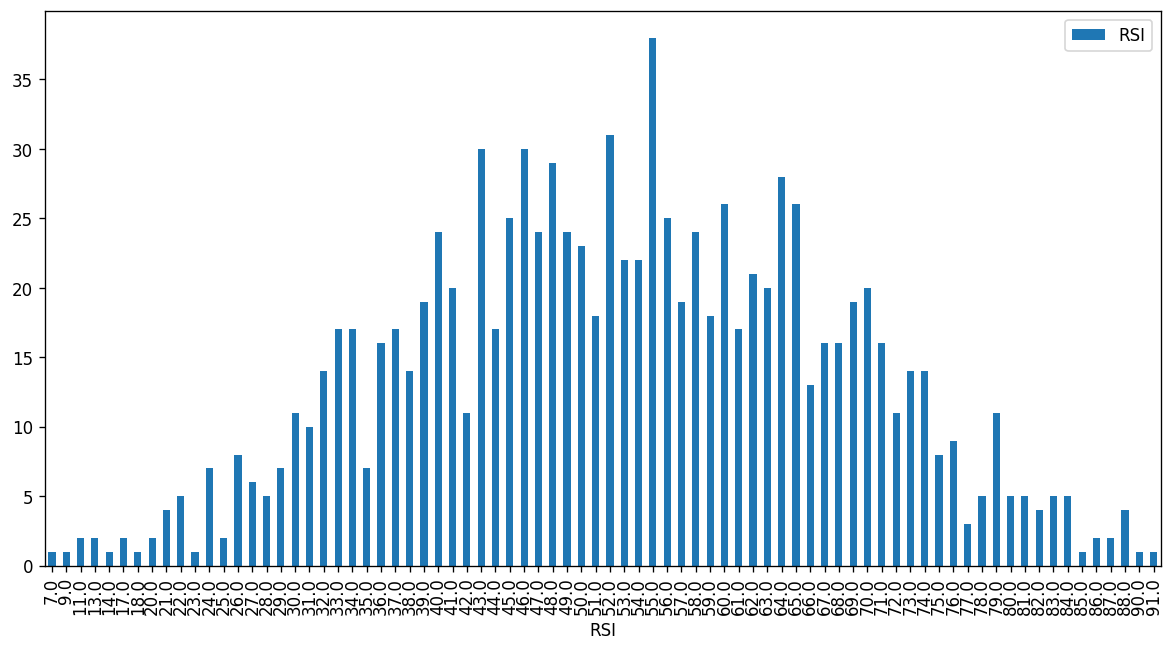

In [67]:
trap_data_grouped_by_rsi = data[data.trap == 'no'].groupby(['RSI'])[['RSI']].count()
trap_data_grouped_by_rsi.plot.bar()